In [3]:
import src.arctic as arctic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Given Data
- from Institute of Atmospheric Physics Kühlungsborn (IAP)
- Differentiated between ERA5 and UA-ICON(NWP) data

1. ERA5: daily means at pressure levels and analysis
    - Intercomparison with Hannachi et al. (2011)
    - SWE1.tar: contains major warming diagnostics
    - SWE1.tar: elliptic diagnostics of Z10
    - SWX1.tar: extended diagnostics (reachable via VPN)
    - SWC1.tar: classfiication synthesis (reachable via VPN)
2. NWP4A60: data at pressure levels and analysis
    - SWM2.tar: major warming diagnostics
    - SWE2.tar: elliptic diagnostics of Z10
    - SWX2.tar: extended diagnostics (VPN)
    - SWC2.tar: classification synthesis (VPN)

#### File structure
netCDF files are 3-dimensional data, investigated with ncdump. The .tar-files contain all output from Christoph Zülickes diagnosis, in particular:
- SWM: ASCII values in 2 files, 
    1. *cen.csv with the major warming events as identified with their central day when the wind turned from westerly to easterly along with some characteristics and
    2. *msw.csv with daily lists with wind and a marker mw for major warming
- SWE: 1 csv file
    - *d.csv: daily list of indices, including the aspect ratio of the mother vortex (ar), centrail latitude (latcent) and area (area)

In [4]:
# Skips all lines starting with C
# Reads only lines starting with D
def read_data(input_file):
    with open(input_file, "r", encoding="utf-8") as f:
        filtered_lines = [line for line in f if line.startswith("D")]
    
    # Convert filtered lines into DataFrame
    from io import StringIO
    df = pd.read_csv(
        StringIO("".join(filtered_lines)),
        delimiter=",",
        low_memory=False
    )
    return df

era5_d = read_data("data/SWXClust/ERA5/e5e1_d.csv")
era5_cen = read_data("data/SWXClust/ERA5/e5m1t-cen.csv")
era5_msw = read_data("data/SWXClust/ERA5/e5m1t-msw.csv")

# nwp_d = read_data("data/SWXClust/NWP4A60/i4a60e2_d.csv")
# nwp_cen= read_data("data/SWXClust/NWP4A60/i4a60m2t-cen.csv")
# nwp_msw = read_data("data/SWXClust/NWP4A60/i4a60m2t-msw.csv")

In [5]:
# delete space in front of strings
def no_white_space(df, sep = ' '):
    col = []
    for c in df.columns:
        col.append(c.split(sep)[-1])
    df.columns = col
    
# convert strings to actual dates
def to_date(df, col, format='mixed'):
    df[col] = pd.to_datetime(df[col], format=format)

# remove white space from column names
no_white_space(era5_d)
no_white_space(era5_cen)
no_white_space(era5_msw)

# no_white_space(nwp_d)
# no_white_space(nwp_cen)
# no_white_space(nwp_msw)

# change string to datetime for better comparison
to_date(era5_d, 'string')
to_date(era5_cen, 'string')
to_date(era5_msw, 'string')

# drop where string is nan (empty lines)
era5_d = era5_d.replace('                   ' ,np.NaN)

era5_d.head()

,D,counter,time,string,year,month,day,hour,level,edge,...,obj_area2,latcent2,loncent2,theta2,ar2,amp0,amp1,amp2,lon1,lon2
0,D,1,2438031.25,1963-01-01 18:00:00,1963,1,1,18,10.0,29.2,...,NaN,NaN,NaN,NaN,NaN,27.9,0.01040,0.0111,5.4,-2.5
1,D,2,2438032.25,1963-02-01 18:00:00,1963,1,2,18,10.0,29.2,...,NaN,NaN,NaN,NaN,NaN,27.9,0.00858,0.0097,3.3,-2.3
2,D,3,2438033.25,1963-03-01 18:00:00,1963,1,3,18,10.0,29.2,...,NaN,NaN,NaN,NaN,NaN,27.9,0.01120,0.0123,0.4,-2.7
3,D,4,2438034.25,1963-04-01 18:00:00,1963,1,4,18,10.0,29.2,...,NaN,NaN,NaN,NaN,NaN,27.8,0.01190,0.0126,2.1,-2.5
4,D,5,2438035.25,1963-05-01 18:00:00,1963,1,5,18,10.0,29.2,...,NaN,NaN,NaN,NaN,NaN,27.8,0.01080,0.0117,7.1,-2.5


## Features in data and their description
#### for *cen files

35x9

| ERA5            | D_cen                       | num                   | counter_cen                                            | time_cen                 | string                  | pers                 | Umax                      | Imax                     | Iacc                            |
|-----------------|-----------------------------|-----------------------|--------------------------------------------------------|--------------------------|-------------------------|----------------------|---------------------------|--------------------------|---------------------------------|
| Values          | 'D'                         | [1,35]                | [26, 21189]                                            | [2438057.25, 2459220.35] | [1963-01-27,2021-05-01] | [2.0,29]             | [-26.9,-0.9]              | [1.7,780.1]              | [1.4,316.5]                     |
| Explanation     | Line belongs to data in csv | Counter of SSW events | Central time counter <br/> index matching measurements | Julian central date      | human readable date     | persistence of event | max. east wind during SSW | max. SSW event intensity | accumulated SSW event intensity |
| Condition       | -                           | -                     |                                                        |                          |                         |                      |                           |                          |                                 |
| Normalization   | no                          | no                    |                                                        |                          |                         |                      |                           |                          |                                 |
| Units           | -                           | -                     | run step                                               | run time                 | run time                | days                 | m/s                       | days m/s                 | days m/s                        |
| Value for model | None                        | Probably none         | Merge key                                              | Merge key                | Merge key               |                      |                           |                          |                                 |

#### for *msw files

21914x6

| ERA5            | D_msw          | counter_msw                                                 | time_msw                 | string                  | u             | MW                  |
|-----------------|----------------|-------------------------------------------------------------|--------------------------|-------------------------|---------------|---------------------|
| Values          | 'D'            | [1, 21914]                                                  | [2438032.25, 2459944.25] | String encoding of date | [-28.8, 73.5] | [0,1] (i.e. no/yes) |
| Explanation     | Line with data | Counter of events, <br/>each daily measurement gets counter | Julian central date      | human readable date     | zonal wind    | marks major warming |
| Condition       | -              |                                                             |                          |                         | ??            |                     |
| Normalization   | no             | no                                                          |                          | no                      |               | no, encode as 0-1   |
| Value for Model | None           | Merge key                                                   | Merge key                | Merge key               | include       | should be included  |



#### for *d files

22403x35

21425 + 978 (D vs. S)

**bold font**: unclear meaning

| ERA5      | Values                   | Explanation                                                                                                  | Condition    | Normalisation  | Value for Model                                                                                           |
|-----------|--------------------------|--------------------------------------------------------------------------------------------------------------|--------------|----------------|-----------------------------------------------------------------------------------------------------------|
| D         | 'D'                      | Line with data                                                                                               |              | -              |                                                                                                           |
| counter   | [1,21914]                | counter of daily measurements                                                                                | -            | -              |                                                                                                           |
| time_d    | [2438031.25, 2459944.25] | Julian day                                                                                                   | -            |                | Merge Key                                                                                                 |
| string    | [1963-01-01, 2022-12-30] | Human readable/string form of date                                                                           |              |                | Merge Key                                                                                                 |
| year      | [1963                    | numeric form of year                                                                                         |              |                | useful                                                                                                    |
| month     | [1,12]                   | numeric form of month                                                                                        |              |                | useful                                                                                                    |
| day       | [1,31]                   | numeric form of day                                                                                          |              |                | useful                                                                                                    |
| hour      | 18                       | numeric form of hour                                                                                         |              |                | None, daily measurement                                                                                   |
| level     | 10                       | Pressure level in hPa, ca. 30km                                                                              |              |                | Currently not huge as not varied,  important for comparison with other studies                            |
| **edge**  | [28.9,        32.3]      | Edge of Vortex? °N? Assumption as circle/ellipsoid around pole?<br/>Strong correlation with generated labels |              |                |                                                                                                           |
| form     | [' D', ' S']             | Form of Vortex: <br/>Displaced (4599 in era5_hannachi), <br/> Split (502 in era5_hannachi)                   |              | Encode as int? | Important, evaluation of clusters                                                                         |
| **area**  | [7105100.0,162460000.0]  | Area of Vortex [km^2]                                                                                        |              |                |                                                                                                           |
| **obj_area** | [11163.0,  3850800.0]    | Objective area of vortex [km^2], diference to area?                                                          |              |                |                                                                                                           |
| latcent   | [50.823, 89.966]         | Latitude of centre                                                                                           |              |                |                                                                                                           |
| loncent   | [-89.993,269.95]         | Longitude of centre                                                                                          |              |                |                                                                                                           |
| theta     | [-1.5707, 1.5797]        | angle of major axis                                                                                          |              |                |                                                                                                           |
| ar        | [1.0001, 4.8253]         | Aspect ratio of polar vortex                                                                                 |              |                |                                                                                                           |
| kurtosis  | [-0.81021,10.235]        | Kurtosis of polar vortex                                                                                     |              |                |                                                                                                           |
| area1     | [na, 29034864.000]       | Area of split vortex 1 [km^2]                                                                                | Split event? |                | Important, but more for evaluation <br/> may irritate cluster algorithms (implicit information of events) |
| obj_area1 | [na, 592939.812]         |                                                                                                              |              |                |                                                                                                           |
| latcent1  | [na, 88.211]             | Latitude of centroid 1                                                                                       |              |                |                                                                                                           |
| loncent1  | [na, 269.912]            | Longitude of centroid 1                                                                                      |              |                |                                                                                                           |
| theta1    | [na, -1.569]             |                                                                                                              |              |                |                                                                                                           |
| ar1       | [na, 3.651]              | Aspect ratio                                                                                                 |              |                |                                                                                                           |
| area2     | [na, 33281544.000]       | Area of split vortex 2 [km^2]                                                                                |              |                |                                                                                                           |
| obj_area2 | [na, 635659.312]         |                                                                                                              |              |                |                                                                                                           |
| latcent2  | [na, 87.856]             |                                                                                                              |              |                |                                                                                                           |
| loncent2  | [na, 202.300]            |                                                                                                              |              |                |                                                                                                           |
| theta2    | [na, -1.570]             |                                                                                                              |              |                |                                                                                                           |
| ar2       | [na, 4.117]              |                                                                                                              |              |                |                                                                                                           |
| **amp0**  | [27.6, 32.3]             | zonal mean                                                                                                   |              |                |                                                                                                           |
| **amp1**  | [0.000024,  0.0489]      | amplitude of wave 1                                                                                          |              |                |                                                                                                           |
| **amp2**  | [0.000003, 0.0543]       | amplitude of wave 2                                                                                          |              |                |                                                                                                           |
| **lon1**  | [-180.0, 180.0]          | angle of wave 1                                                                                              |              |                |                                                                                                           |
| **lon2**  | [-180.0, 180.0]          | angle of wave 2                                                                                              |              |                |                                                                                                           |

### Focus and To Do
- [x] Understand relation between data sets, merge via 'string' (i.e. concrete date) possible
- [x] ERA5 Data, replicate results from Hannachi
- [ ] descriptive statistics:
    - [ ] PSA/SSA
    - [x] correlation matrix/chi2
    - [ ] gap statistic
- [x] hierarchical Clustering, k-means, k-nearest neighbours


In [6]:
# merge era5 data to one big dataframe
era5 = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])
era5.columns

Index(['D_d', 'counter_d', 'time_d', 'string', 'year', 'month', 'day', 'hour',
       'level', 'edge', 'form', 'area', 'obj_area', 'latcent', 'loncent',
       'theta', 'ar', 'kurtosis', 'area1', 'obj_area1', 'latcent1', 'loncent1',
       'theta1', 'ar1', 'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2',
       'ar2', 'amp0', 'amp1', 'amp2', 'lon1', 'lon2', 'D_msw', 'counter_msw',
       'time_msw', 'u', 'MW', 'D_cen', 'num', 'counter_cen', 'time_cen',
       'pers', 'Umax', 'Imax', 'Iacc'],
      dtype='object')

## Reconstruction of same conditions as Hannachi et al.
- time: winterperiod (december to march) from 1958 to 2002, activity peaks in dec - jan, oscilliation period around 120-130d
    - **Note: only data after 1963 available 
- 7 stratospheeric variables:

| temp. (lat1)     | temp (lat2)      | temp. (lat3)     | avg. wind (lat1)      | avg. wind (lat2) | wave-1                    | wave-2                    |
|------------------|------------------|------------------|-----------------------|------------------|---------------------------|---------------------------|
| Zonally averaged | Zonally averaged | Zonally averaged | Zonally averaged <br/ | Zonally averaged | Normalised by zonal winds | Normalised by zonal winds |
| 60-70°N          | 70-80°N          | 80-90°N          | 60-70°N               | 70-80°N          | 60°N                      | 60°N                      |

- 7 pressure levels between 100 to 1hPa
- geometrical features: latitude centroid (lat), area (area), aspect ratio (AR) - kurtosis omitted due to domination of outliers

#### Approaches
1. Hierarchical Clustering
    - Used distance: Euclidean distance
    - Distance between Cluster: Complete Linkage to avoid chain and spheroidal tendencies of single and average linkage
    - Gap statistic to find number of clusters with Poisson point process (standard)
    - SSA to deal with seasonality and its variation

|               | between points in Cluster | Different                                  |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

In [14]:
# correlation within data
arctic.plot_correlation(era5, savefig="output/corr.png")

,counter_d,time_d,year,month,day,hour,edge,area,obj_area,latcent,loncent,theta,ar,kurtosis,amp0,amp1,amp2,lon1,lon2,counter_msw,time_msw,u,num,counter_cen,time_cen,pers,Umax,Imax,Iacc
counter_d,1.000000,1.000000,0.999861,0.016511,0.001396,-0.007430,0.106786,0.000216,0.007926,0.002436,-0.006908,0.042536,0.000014,-0.026154,0.065116,0.000843,-0.003060,0.076656,-0.006827,1.000000,1.000000,0.005623,0.994892,1.000000,1.000000,0.345318,-0.304174,0.346898,0.349767
time_d,1.000000,1.000000,0.999861,0.016511,0.001396,-0.007429,0.106786,0.000216,0.007926,0.002436,-0.006908,0.042536,0.000014,-0.026154,0.065116,0.000843,-0.003060,0.076656,-0.006827,1.000000,1.000000,0.005623,0.994892,1.000000,1.000000,0.345318,-0.304174,0.346898,0.349767
year,0.999861,0.999861,1.000000,-0.000098,-0.000165,-0.007607,0.106332,0.000459,0.008376,-0.002196,-0.007760,0.042507,0.003474,-0.025498,0.065564,0.003065,-0.001130,0.075872,-0.003869,0.999861,0.999861,0.003819,0.995198,0.999831,0.999831,0.350061,-0.306254,0.350078,0.353003
month,0.016511,0.016511,-0.000098,1.000000,0.010398,0.010818,0.030757,-0.013542,-0.026855,0.279218,0.051541,0.002942,-0.210115,-0.040971,-0.023787,-0.135728,-0.118218,0.049582,-0.176736,0.016511,0.016511,0.106152,-0.179499,-0.154809,-0.154809,-0.322160,0.176622,-0.246183,-0.249881
day,0.001396,0.001396,-0.000165,0.010398,1.000000,-0.001743,0.005750,0.015891,0.007249,0.007271,0.012931,-0.008935,-0.002265,0.006479,0.005492,-0.005348,-0.005269,-0.016289,0.009939,0.001396,0.001396,-0.006212,-0.198575,-0.199487,-0.199487,0.046391,-0.110264,0.152079,0.151259
hour,-0.007430,-0.007429,-0.007607,0.010818,-0.001743,1.000000,0.001581,0.002926,-0.002150,0.012825,0.004043,0.003201,-0.012484,-0.001101,0.001283,-0.004139,0.004266,0.007762,-0.007842,-0.007430,-0.007429,-0.001743,nan,nan,nan,nan,nan,nan,nan
edge,0.106786,0.106786,0.106332,0.030757,0.005750,0.001581,1.000000,0.794349,0.390113,0.377321,0.383453,0.081150,-0.499579,-0.145296,0.971513,-0.758350,-0.770073,0.144130,0.573240,0.106786,0.106786,-0.882299,0.528822,0.505340,0.505340,0.188884,-0.283074,0.257657,0.303055
area,0.000216,0.000216,0.000459,-0.013542,0.015891,0.002926,0.794349,1.000000,0.717287,0.468824,0.332220,0.018174,-0.517532,-0.315409,0.734731,-0.603317,-0.589693,0.113875,0.506775,0.000216,0.000216,-0.676032,0.185853,0.174294,0.174294,0.184008,-0.184487,0.156411,0.275162
obj_area,0.007926,0.007926,0.008376,-0.026855,0.007249,-0.002150,0.390113,0.717287,1.000000,0.345357,0.150915,-0.041366,-0.254603,-0.261538,0.275296,-0.195166,-0.185152,0.078114,0.232449,0.007926,0.007926,-0.233548,0.234510,0.252866,0.252866,0.111456,-0.184034,0.174294,0.226082
latcent,0.002436,0.002436,-0.002196,0.279218,0.007271,0.012825,0.377321,0.468824,0.345357,1.000000,0.197647,0.046106,-0.419397,-0.373021,0.255958,-0.288201,-0.213531,0.221969,0.029114,0.002436,0.002436,-0.101598,-0.167634,-0.189540,-0.189540,0.116443,-0.044858,0.090771,0.124332


    ## Jupyter Notebook to demonstrate usage of ARTIC
### Open questions
- Connectivity matrix from Hannachi et al.? Do they have one? With what created?
- Different amount of samples between *_d and *_msw
- Differences between era40 data and era5 data

#### To Do
- [ ] Check wie Cluster mit Daten/Split events zusammen passen
- [ ] Check Area (big correlation with labels) and check what filtered area in Hannachi et al. is

### Handling NaN Values
- *cen-file produces most NaN values in data due to merch and marking special events &rArr; 0 not used in *num, counter, time, pers, Imax, Iacc*,**Umax** has values only below -0.9 

In [15]:
# reproduce same circumstances as hannachi et al.
# time winterperiod (december to march) 1958 - 2002 
var = ['year', 'month','day', # removed string so everything is a numeric datetype
       'edge', 'theta',
       'area', 'latcent', 'loncent', 'ar',  # geometric variables (latcent, area, ar, excess kurtosis) from Hannachi et al., level = 10 for all measurements -> droped
       'amp0', 'amp1', 'amp2', 'lon1', 'lon2', # unclear importance, included in this version
       'MW', 'u', # variables from *msw file
       'pers', 'Umax', 'Imax', 'Iacc', # variables form *cen file
       'form'] # Discuss! Usage of form!

# enforce same time constraints
era5_hannachi = era5[(era5['string'] < '01-01-2003') & 
                     (era5['month']).isin([12,1,2,3])][var]

# handling NaN values and string encodings
era5_hannachi['MW'] = pd.to_numeric(era5_hannachi.MW.replace({'   ': 0, ' MW' : 1}))
era5_hannachi[era5_cen.columns[-4:]] = era5_hannachi[era5_cen.columns[-4:]].fillna(0) 
# check for completeness
era5_hannachi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4850 entries, 0 to 14609
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     4850 non-null   int64  
 1   month    4850 non-null   int64  
 2   day      4850 non-null   int64  
 3   edge     4850 non-null   float64
 4   theta    4850 non-null   float64
 5   area     4850 non-null   float64
 6   latcent  4850 non-null   float64
 7   loncent  4850 non-null   float64
 8   ar       4850 non-null   float64
 9   amp0     4850 non-null   float64
 10  amp1     4850 non-null   float64
 11  amp2     4850 non-null   float64
 12  lon1     4850 non-null   float64
 13  lon2     4850 non-null   float64
 14  MW       4850 non-null   int64  
 15  u        4850 non-null   float64
 16  pers     4850 non-null   float64
 17  Umax     4850 non-null   float64
 18  Imax     4850 non-null   float64
 19  Iacc     4850 non-null   float64
 20  form     4850 non-null   object 
dtypes: float64(16), in

##### Assumption
- Data are ready to use and preprocessed

In [16]:
era5_hannachi['form'] = era5_hannachi['form'].replace({' D' : 0, ' S': 1})
#var[:-1] # ohne D_d und form

In [17]:
from sklearn.cluster import AgglomerativeClustering
X = era5_hannachi[var[:-1]]
hc = AgglomerativeClustering(n_clusters=3,
                             linkage='complete',
                             compute_distances=True).fit(X)
hc_label = hc.labels_

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42).fit(X)
kmeans_label = kmeans.labels_

In [22]:
era5_hannachi['hc'] = hc_label
era5_hannachi['kmeans'] = kmeans_label
# compare label with mw, c/d, s/d
corr = era5_hannachi.corr()
corr[['kmeans', 'hc']].style.background_gradient(vmin=-1, vmax=1, cmap='RdBu')

,kmeans,hc
year,0.040834,-0.003035
month,0.091205,0.060362
day,0.035035,-0.012541
edge,0.234007,-0.434524
theta,0.044013,-0.026496
area,0.383134,-0.809727
latcent,-0.293999,0.154594
loncent,-0.082777,-0.031297
ar,0.215644,-0.069831
amp0,0.277841,-0.464094


In [23]:
print(era5_hannachi.shape)
print("Label distribution by hierarchical clustering: ")
print('0 : ', era5_hannachi[era5_hannachi.hc == 0].shape) # 74
print('1 : ', era5_hannachi[era5_hannachi.hc == 1].shape) # 403
print('2 : ', era5_hannachi[era5_hannachi.hc == 2].shape) # 4624

print("Label distribution by kmeans clustering: ")
print('0 : ', era5_hannachi[era5_hannachi.kmeans == 0].shape) # 74
print('1 : ', era5_hannachi[era5_hannachi.kmeans == 1].shape) # 403
print('2 : ', era5_hannachi[era5_hannachi.kmeans == 2].shape) # 4624
print('3: ', era5_hannachi[era5_hannachi.kmeans==3].shape)

(4850, 23)
Label distribution by hierarchical clustering: 
0 :  (74, 23)
1 :  (350, 23)
2 :  (4426, 23)
Label distribution by kmeans clustering: 
0 :  (2675, 23)
1 :  (79, 23)
2 :  (2096, 23)
3:  (0, 23)


### Results from Hannachi et al.

| AR and Latc of vortex/AR, Lat, filtered vortex area | D  | U  | S  | Total |
|-----------------------------------------------------|----|----|----|-------|
| D                                                   | 7  |  3 | 0  | 10    |
| U                                                   | 4  | 80 | 2  | 86    |
| S                                                   | 1  | 0  | 3  | 4     |
| Total                                               | 12 | 83 | 5  | 100   |

### Results with Agglomorative Clustering:

| Label | Absolut | Perc (%) | Comment                                                                                                      |
|-------|---------|----------|--------------------------------------------------------------------------------------------------------------|
| 0     | 74      | 1,5      | Probably S<br/>Remains the same when removing other features<br/>74 when only area, latcent and ar were used |
| 1     | 403     | 8        | Probably D  <br/> Varies wildly when features removed                                                        |
| 2     | 4624    | 90,6     | Probably U  <br/>Varies wildly when features removed                                                         |
| Total | 5101    | 100      | --                                                                                                           |

Influence of different linkages:
- complete: used by Hannachi, dendogram does not indicate 3 clusters
- ward: appears similar to kmeans in distribution
- single: makes very weird Cluster with distribution 70, 4, 5027; indicates 3 Clusters
- average: makes also weird Cluster with distribution 70, 23, 5008; indicates 3 Clusters

### Results with kmeans Clustering:

| Label | Absolut | Perc (%)   | Comment                                                                                                      |
|-------|---------|------------|--------------------------------------------------------------------------------------------------------------|
| 0     | 2000    | 39,25      | Maybe D  <br/> Varies wildly, depending on features and random seed                                          |
| 1     | 79      | 1,5        | Probably S<br/>Remains the same when removing other features<br/>74 when only area, latcent and ar were used |
| 2     | 3022    | 59,25      | Maybe U  <br/>Varies wildly, just as D                                                                       |
| Total | 5101    | 100        | --                                                                                                           

#### Evaluation
S and U are underrepresented. Different measures?
Go for troubleshooting:
- Outliers? (~75?)
- Can I - based on my available data - differentiate between S, U, D?
- Data differences (s. previous part)
- Description of found cluster matching with Hannachi/general what are they?

Hierarchical cluster depends severly on **area**

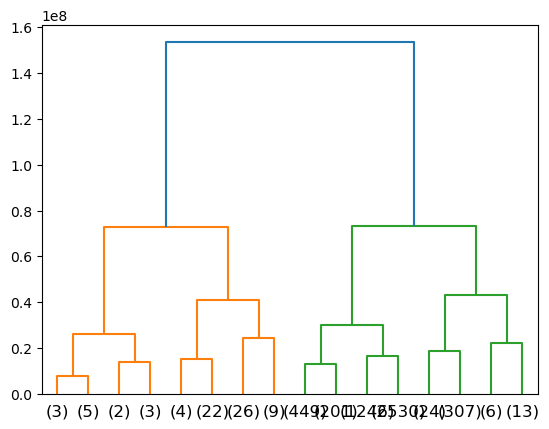

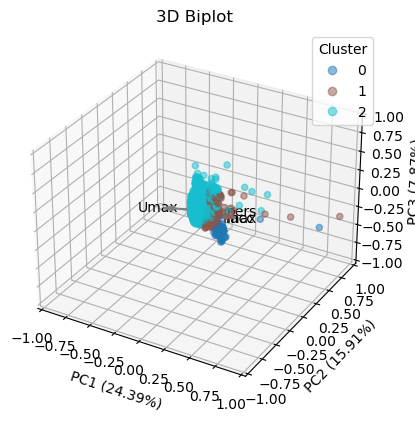

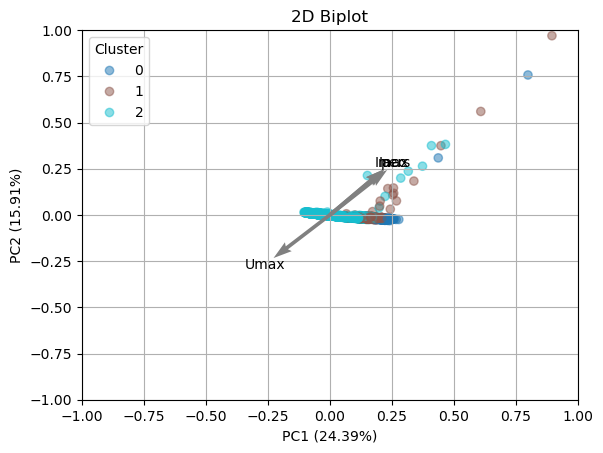

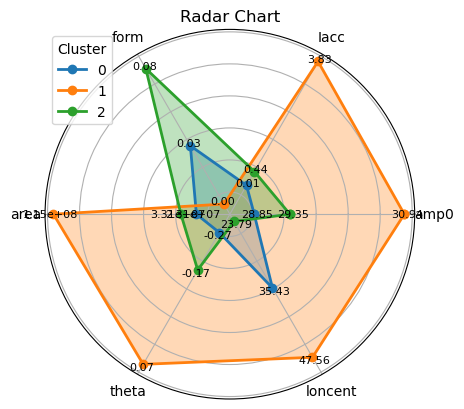

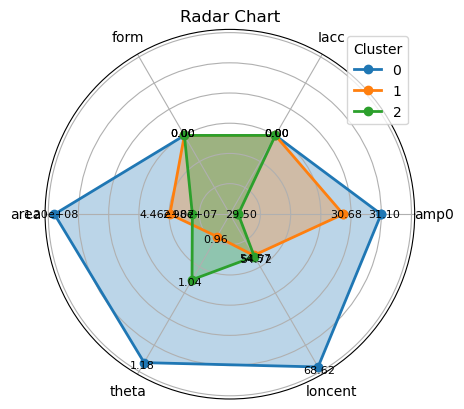

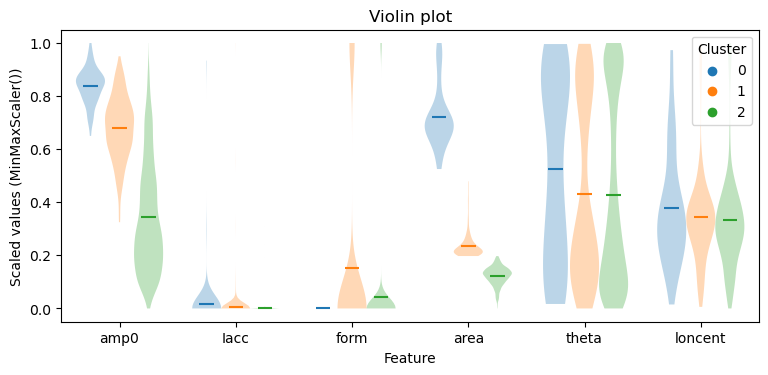

In [39]:
# Dendrogram
arctic.plot.plot_dendrogram(hc, truncate_mode='level', p=3, savefig='output/hc.png')

# Biplot
pc=5
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_3D.png', n_arrows=2)
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', n_arrows=2, savefig='output/pca_era5_2D.png')
# note "label" excluded from pca due to duplication of data.
era5_hannachi['label'] = era5_hannachi['hc']
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_hc_3D.png')
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', savefig='output/pca_era5_hc_2D.png')
#era5_hannachi['label'] = era5_hannachi['kmeans']
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_kmeans_3D.png')
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', savefig='output/pca_era5_kmeans_2D.png')

# Radar chart
def own_agg(x):
    return x.quantile(0.75)
arctic.plot.plot_radar(era5_hannachi, label='kmeans')
arctic.plot.plot_radar(era5_hannachi, agg_func=own_agg)

# Violinplot
arctic.plot_violin(era5_hannachi)

In [46]:
# check time integrity of clustering
print("Distribution cluster: ", era5_hannachi.hc.value_counts())
print("Distribution form: ", era5_hannachi.form.value_counts())
era5_hannachi.groupby(['year', 'hc']).count()['label']

Distribution cluster:  hc
2    4426
1     350
0      74
Name: count, dtype: int64
Distribution form:  form
0    4599
1     251
Name: count, dtype: int64


year  hc
1963  0       6
      1      10
      2     105
1964  0      13
      1       4
           ... 
2001  0       1
      1      30
      2      90
2002  1       2
      2     119
Name: label, Length: 84, dtype: int64

In [45]:
era5_hannachi.groupby(['form', 'hc']).count()['label']

form  hc
0     0       74
      1      297
      2     4228
1     1       53
      2      198
Name: label, dtype: int64